In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from prophet.plot import plot_components
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
from statsmodels.graphics import tsaplots
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

# Suppress specific statsmodels warnings about frequency
warnings.filterwarnings('ignore', 'No frequency information was provided')
warnings.filterwarnings('ignore', 'No supported index is available')
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [21]:
co = pd.read_csv("data/co_clean.csv", parse_dates=['date_time'])

In [26]:
co_monthly = co.groupby([co['date_time'].dt.year.rename('year'), 
                         co['date_time'].dt.month.rename('month'),
                         'station'])['co'].mean().reset_index()

co_monthly['date'] = pd.to_datetime(co_monthly[['year','month']].assign(day=1))
co_monthly = co_monthly.drop(["year","month"], axis =1)

In [28]:
# remove record from prior 2012
co_monthly.set_index('date', inplace=True)
co_monthly = co_monthly[co_monthly.index >= '2012-01-01']

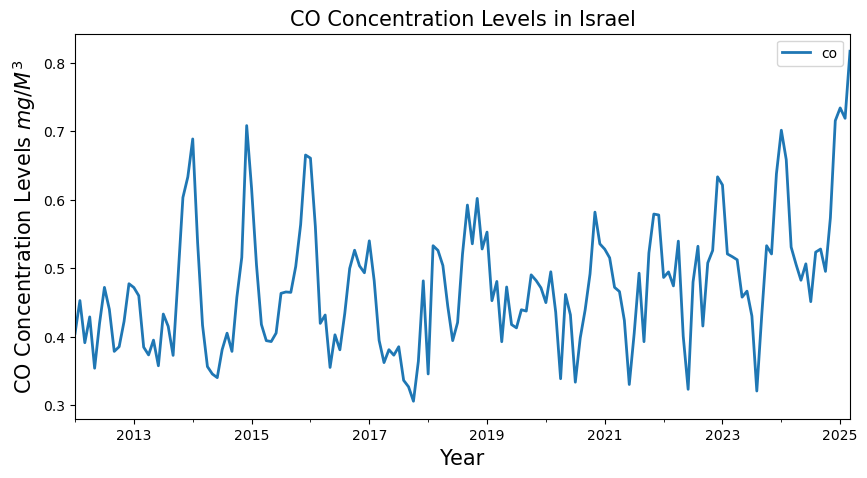

In [30]:
df = (co_monthly.groupby(co_monthly.index)["co"]
      .mean()
      .reset_index()
      .set_index('date'))
df.plot(figsize=(10,5), linewidth=2, fontsize=10)
plt.title("CO Concentration Levels in Israel",fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.ylabel('CO Concentration Levels $mg/M^3$', fontsize=15);

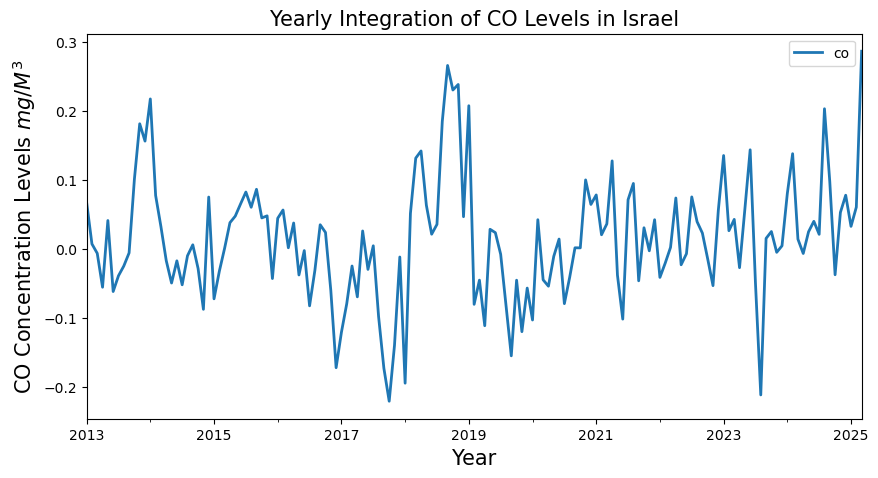

In [35]:
year_integration = df.diff(periods=12)
year_integration = year_integration.dropna()
year_integration.plot(figsize=(10,5), linewidth=2, fontsize=10)
plt.title("Yearly Integration of CO Levels in Israel", fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.ylabel('CO Concentration Levels $mg/M^3$', fontsize=15);

Significant PACF lags (exceeding the ±0.165 threshold):
At lag 1 (approx. 31 days 00:00:00 offset): PACF = -0.2846 exceeds ±0.1650
At lag 2 (approx. 62 days 00:00:00 offset): PACF = -0.1878 exceeds ±0.1650
At lag 3 (approx. 93 days 00:00:00 offset): PACF = -0.1876 exceeds ±0.1650
At lag 9 (approx. 279 days 00:00:00 offset): PACF = 0.1970 exceeds ±0.1650
At lag 11 (approx. 341 days 00:00:00 offset): PACF = 0.2328 exceeds ±0.1650
At lag 12 (approx. 372 days 00:00:00 offset): PACF = -0.4150 exceeds ±0.1650


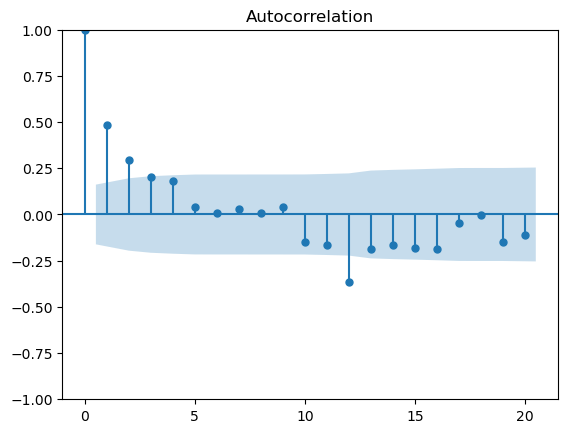

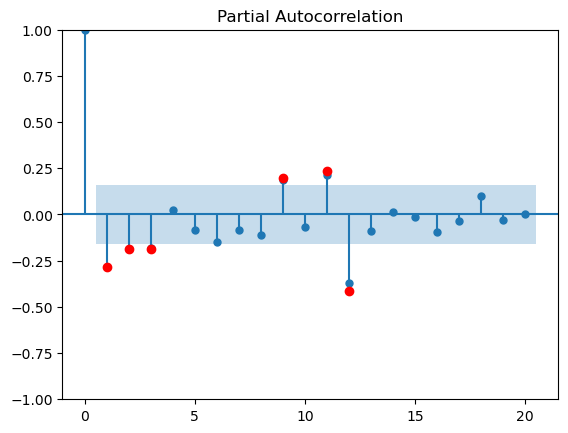

In [55]:
tsaplots.plot_acf(year_integration, lags=20);
plt.savefig("visualizations/correlograms_monthly.png")
# Plot PACF with colored significant points
fig, ax = plt.subplots(1, 1)
pacf_plot = tsaplots.plot_pacf(year_integration.diff(1).dropna(), lags=20, ax=ax)


# Get the PACF values and confidence intervals
pacf_values = tsaplots.pacf(year_integration['co'].diff(1).dropna(), nlags=20)
confidence_interval = 2 / np.sqrt(len(year_integration))

# Print a header for insights
print("Significant PACF lags (exceeding the ±{:.3f} threshold):".format(confidence_interval))

# Optionally, compute the median time difference between observations.
# This assumes that your datetime index has approximately regular frequency.
time_delta = year_integration.index.to_series().diff().median()

# Color points and print insights where PACF values exceed the confidence limits.
for i, value in enumerate(pacf_values):
    if i > 0 and abs(value) > confidence_interval:  # Skip lag 0
        # Compute an estimated time offset for the lag.
        time_offset = i * time_delta
        # Print textual insight
        print(f"At lag {i} (approx. {time_offset} offset): PACF = {value:.4f} exceeds ±{confidence_interval:.4f}")
        # Highlight the significant lag on the PACF plot
        ax.plot(i, value, 'ro')



In [39]:
# Split the data into train and test sets (80% training, 20% testing)
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (127, 1)
Test shape: (32, 1)


In [49]:
models = [SARIMAX(train, order=(1,0,1), seasonal_order = (0,1,1,12)),
          SARIMAX(train, order=(0,0,1), seasonal_order = (0,1,1,12)),
          SARIMAX(train, order=(1,0,2), seasonal_order = (0,1,1,12)),
          SARIMAX(train, order=(0,0,2), seasonal_order = (0,1,1,12)),
         SARIMAX(train, order=(1,1,1), seasonal_order = (0,1,1,12))]
          
model_results = []
for model in models:
    results = model.fit(disp=False)
    # Get residuals for RMSE and MAE
    residuals = results.resid
    rmse = np.sqrt(np.mean(residuals**2))
    mae = np.mean(np.abs(residuals))

    model_results.append({
        'model': model,
        'order': model.order,
        'seasonal_order': model.seasonal_order,
        'aic': results.aic,
        'bic': results.bic,
        'rmse': rmse,
        'mae': mae,
        'results': results
    })

# Create a comparison DataFrame
comparison_df = pd.DataFrame([
    {
        'Order': f"SARIMA{res['order']}{res['seasonal_order']}",
        'AIC': res['aic'],
        'BIC': res['bic'],
        'RMSE': res['rmse'],
        'MAE': res['mae']
    }
    for res in model_results
])

print("Model Comparison:")
print(comparison_df.sort_values('BIC'))

Model Comparison:
                          Order         AIC         BIC      RMSE       MAE
0  SARIMA(1, 0, 1)(0, 1, 1, 12) -302.383168 -291.403440  0.142302  0.083201
3  SARIMA(0, 0, 2)(0, 1, 1, 12) -301.370332 -290.390603  0.142397  0.082992
1  SARIMA(0, 0, 1)(0, 1, 1, 12) -296.136952 -287.902156  0.143332  0.084417
2  SARIMA(1, 0, 2)(0, 1, 1, 12) -300.524037 -286.799377  0.142269  0.083134
4  SARIMA(1, 1, 1)(0, 1, 1, 12) -293.582993 -282.638199  0.074599  0.053820


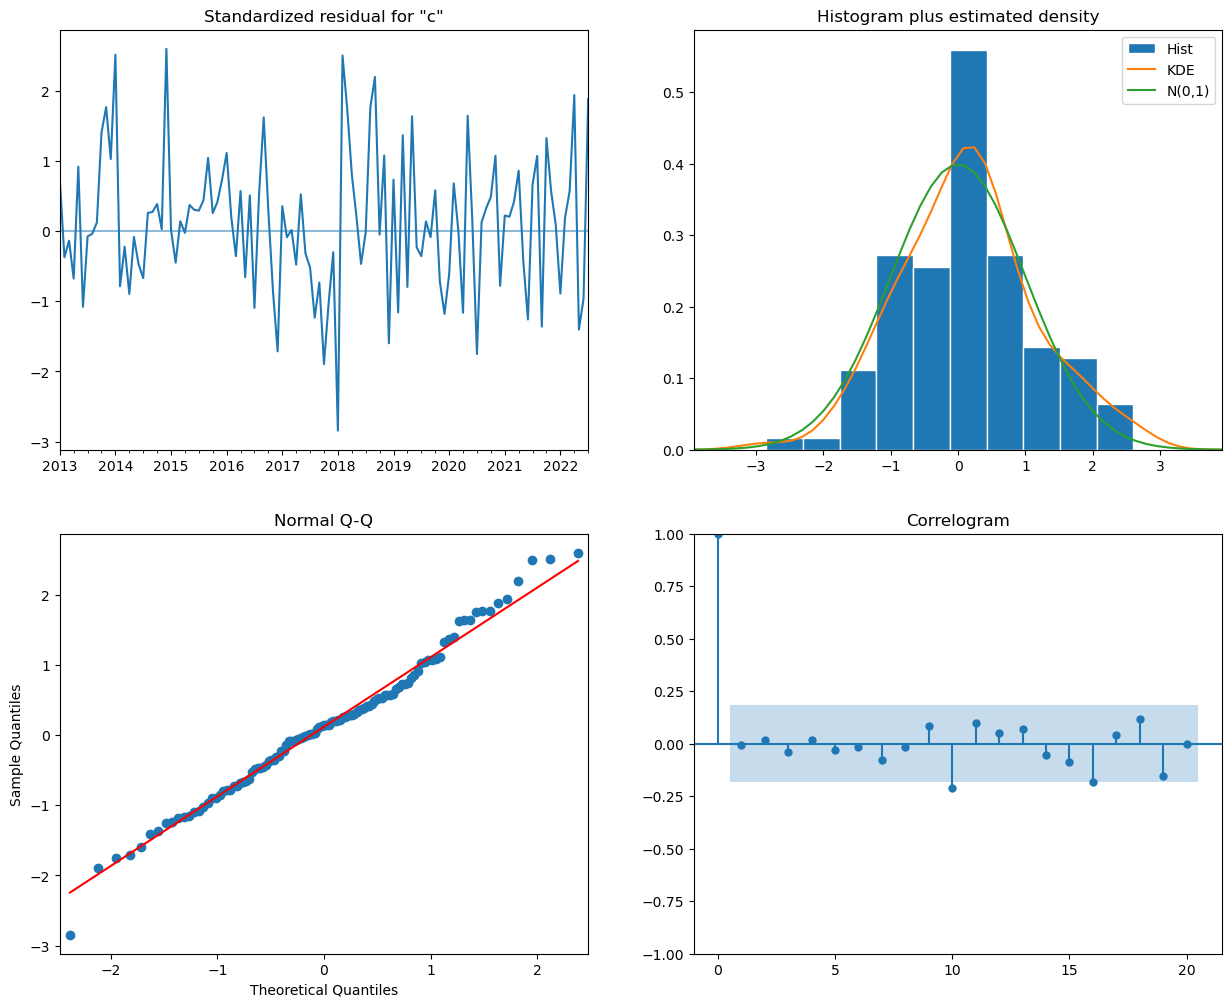

In [52]:
# Store the best model based on the lowest BIC and display its diagnostics
best_model = min(model_results, key=lambda x: x['bic'])
best_model['results'].plot_diagnostics(lags=20, figsize=(15, 12))
plt.show()